## Package imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from pandas_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder # StandardScaler

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack

import pyarrow
# import pickle

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

## Import data

In [3]:
data = pd.read_parquet('./input/consumer_complaints.parquet')
data.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",None,None,None,U.S. Bancorp,CA,95993,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",None,None,None,Wells Fargo & Company,CA,91104,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,None,Incorrect information on credit report,Account status,None,None,Wells Fargo & Company,NY,11764,None,None,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,None,None,"Navient Solutions, Inc.",MD,21402,None,None,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,None,None,Resurgent Capital Services L.P.,GA,30106,None,None,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,None,Application processing delay,None,None,None,Capital One,NY,12206,None,None,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,None,Credit line increase/decrease,None,None,None,Wells Fargo & Company,AZ,85730,None,None,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,IL,60660,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,GA,30016,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",None,None,None,"SunTrust Banks, Inc.",CA,94551,None,None,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In [4]:
# save data to df so won't have to reload data if need to start over with df.
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [6]:
df.shape

(555957, 18)

In [7]:
list(df.columns)

['date_received',
 'product',
 'sub_product',
 'issue',
 'sub_issue',
 'consumer_complaint_narrative',
 'company_public_response',
 'company',
 'state',
 'zipcode',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'date_sent_to_company',
 'company_response_to_consumer',
 'timely_response',
 'consumer_disputed?',
 'complaint_id']

In [8]:
# Only keep records with a complaint narrative for NLP
# Will reduce dataset from half million to ~67k which is still well sized 
df = df[~df['consumer_complaint_narrative'].isnull()].reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  consumer_consent_provided     66806 non-null  object
 12  submitted_via                 66806 non-null  object
 13  date_sent_to_com

In [10]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
3,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I have an open and current mortgage with Chase...,None,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
4,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,None,XXXX was submitted XX/XX/XXXX. At the time I s...,None,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137


## Explore dataset with pandas profiling
- ### Quick way to look at distributions, find missing values, etc.

In [11]:
# don't output within notebook because it will affect view in github
profile = ProfileReport(df, title="Consumer Complaints EDA Profiling Report")

In [12]:
# save EDA profile report to separate html
profile.to_file("./EDA_outputs/Consumer Complaints EDA Profiling Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary of dataset profile report findings:

- #### date_received: categorical, no missing values, convert to datetime
- #### product: TARGET! categorical, no missing values, convert with LabelEncoder()
- #### sub_product: categorical, missing 30.6% of values, frequency encode with potential flag variables for low-occurring and missing
- #### issue: categorical, no missing values, frequency encode with potential flag variable for low-occurring
- #### sub_issue: categorical, missing 50.7% of values, DROP or frequency encode with potential flag variables for low-occurring and missing
- #### consumer_complaint_narrative: TEXT, no missing values, various NLP methodologies and potential flag variable for low-occurring but duplicate narratives
- #### company_public_response: categorical, missing 50.9% of values, DROP or frequency encode with potential flag variables for low-occurring and missing
- #### company: categorical, no missing values, frequency encode with potential flag variable for low-occurring
- #### state: categorical, missing 0.3% of values, frequency encode with potential flag variables for low-occurring and missing
- #### zipcode: categorical (slightly ordinal), missing 0.3% of values, frequency or label encode with potential flag variables for low-occurring and missing
- #### tags: categorical, missing 82.9% of values, Don't drop because missing is taken as non servicemember and not older - one-hot or label encode including flag variable for missing
- #### consumer_consent_provided: categorical, no missing values, DROP because univariate (consent always provided for this dataset)
- #### submitted_via: categorical, no missing values, DROP because univariate (all submissions via web)
- #### date_sent_to_company: categorical, no missing values, convert to datetime
- #### company_response_to_consumer: categorical, no missing values, one-hot or label encode with potential flag variable for low-occurring
- #### timely_response: boolean, no missing values, binary encode
- #### consumer_disputed?: boolean, no missing values, binary encode
- #### complaint_id: complaint identifier index, not needed


## Drop univariate variables

In [13]:
df = df.drop(['consumer_consent_provided', 'submitted_via'], axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  date_sent_to_company          66806 non-null  object
 12  company_response_to_consumer  66806 non-null  object
 13  timely_response 

In [15]:
df.head(3)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,03/19/2015,Closed with explanation,Yes,No,1290516
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,03/19/2015,Closed with explanation,Yes,No,1290492
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,03/19/2015,Closed with explanation,Yes,Yes,1290524


## Explore target value and transform with LabelEncoder

In [16]:
product = df['product'].value_counts()
print(product)

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


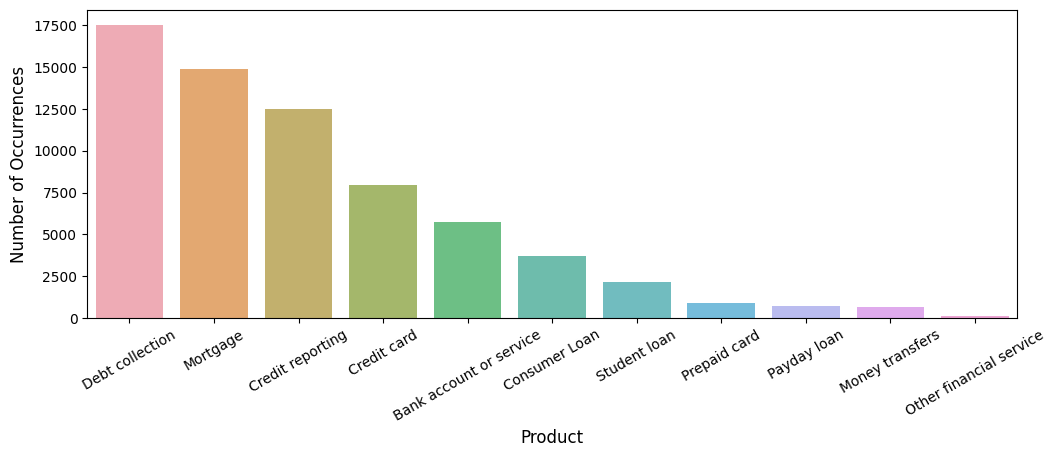

In [17]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [18]:
df['label'] = LabelEncoder().fit_transform(df['product'])

In [19]:
df.head(3)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,label
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,03/19/2015,Closed with explanation,Yes,No,1290516,4
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,03/19/2015,Closed with explanation,Yes,No,1290492,1
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,03/19/2015,Closed with explanation,Yes,Yes,1290524,6


## Convert date values with datetime and create new feature for time between date_received and date_sent_to_company 

In [20]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df['date_received'] = np.where(
    pd.isna(df['date_received']) == False,
    pd.to_datetime(df['date_received'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [21]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df['date_sent_to_company'] = np.where(
    pd.isna(df['date_sent_to_company']) == False,
    pd.to_datetime(df['date_sent_to_company'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [22]:
# Create new feature that is the difference in days between when a complaint was received and when it was sent to company
df['days_between_receipt_and_sent'] = np.where(
    (pd.isna(df['date_received']) == False) & (pd.isna(df['date_sent_to_company']) == False),
    (df['date_sent_to_company'] - df['date_received']).dt.days,
    None
)

In [23]:
# Change new feature from datetime object to integer
df['days_between_receipt_and_sent'] = pd.to_numeric(df['days_between_receipt_and_sent'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   date_received                  66806 non-null  object
 1   product                        66806 non-null  object
 2   sub_product                    46351 non-null  object
 3   issue                          66806 non-null  object
 4   sub_issue                      32932 non-null  object
 5   consumer_complaint_narrative   66806 non-null  object
 6   company_public_response        32776 non-null  object
 7   company                        66806 non-null  object
 8   state                          66620 non-null  object
 9   zipcode                        66617 non-null  object
 10  tags                           11417 non-null  object
 11  date_sent_to_company           66806 non-null  object
 12  company_response_to_consumer   66806 non-null  object
 13  t

In [25]:
df.head(3)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,label,days_between_receipt_and_sent
0,2015-03-19,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,2015-03-19,Closed with explanation,Yes,No,1290516,4,0
1,2015-03-19,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,2015-03-19,Closed with explanation,Yes,No,1290492,1,0
2,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,2015-03-19,Closed with explanation,Yes,Yes,1290524,6,0


## Frequency encode 'sub_product' variable and add flag variables for missing/low-occurring

In [52]:
sub_product_freq = df.groupby('sub_product').size() / len(df)
sub_product_freq


sub_product
(CD) Certificate of deposit               0.001796
Auto                                      0.005973
Cashing a check without an account        0.000838
Check cashing                             0.000344
Checking account                          0.057166
Conventional adjustable mortgage (ARM)    0.035596
Conventional fixed mortgage               0.099377
Credit card                               0.052645
Credit repair                             0.000210
Debt settlement                           0.000479
Domestic (US) money transfer              0.005673
Electronic Benefit Transfer / EBT card    0.000015
FHA mortgage                              0.041553
Federal student loan                      0.003548
Foreign currency exchange                 0.000150
General purpose card                      0.006571
Gift or merchant card                     0.000943
Government benefit payment card           0.000539
Home equity loan or line of credit        0.014190
I do not know      

In [44]:
# Vectorized operation to frequency encode sub_product category
df['sub_product_freq'] = np.where(
    pd.isna(df['sub_product']) == False,
    df['sub_product'].map(sub_product_freq),
    -1
)

In [47]:
# Vectorized operation to create binary flag variable for missing sub_product
df['sub_product_null_flag'] = np.where(
    pd.isna(df['sub_product']) == True,
    1,
    0
)

In [48]:
# Vectorized operation to create binary flag variable for low-occuring sub_product
df['sub_product_low_flag'] = np.where(
    (df['sub_product_freq'] <= 0.01) & (pd.isna(df['sub_product']) == False),
    1,
    0
)

## Frequency encode 'issue' variable and add flag variable for low-occurring

In [53]:
issue_freq = df.groupby('issue').size() / len(df)
issue_freq


issue
APR or interest rate                        0.005703
Account opening, closing, or management     0.033350
Account terms and changes                   0.000105
Adding money                                0.000973
Advertising and marketing                   0.005808
Advertising, marketing or disclosures       0.000165
Application processing delay                0.000494
Application, originator, mortgage broker    0.024189
Applied for loan/did not receive money      0.000689
Arbitration                                 0.000434
Balance transfer                            0.001706
Balance transfer fee                        0.000314
Bankruptcy                                  0.000748
Billing disputes                            0.018292
Billing statement                           0.004506
Can't contact lender                        0.002425
Can't repay my loan                         0.010478
Can't stop charges to bank account          0.001093
Cash advance                            

In [54]:
# Vectorized operation to frequency encode issue category
df['issue_freq'] = np.where(
    pd.isna(df['issue']) == False,
    df['issue'].map(issue_freq),
    -1
)

In [55]:
# Vectorized operation to create binary flag variable for low-occuring issue
df['issue_low_flag'] = np.where(
    (df['issue_freq'] <= 0.01) & (pd.isna(df['issue']) == False),
    1,
    0
)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_received                  66806 non-null  object 
 1   product                        66806 non-null  object 
 2   sub_product                    46351 non-null  object 
 3   issue                          66806 non-null  object 
 4   sub_issue                      32932 non-null  object 
 5   consumer_complaint_narrative   66806 non-null  object 
 6   company_public_response        32776 non-null  object 
 7   company                        66806 non-null  object 
 8   state                          66620 non-null  object 
 9   zipcode                        66617 non-null  object 
 10  tags                           11417 non-null  object 
 11  date_sent_to_company           66806 non-null  object 
 12  company_response_to_consumer   66806 non-null 

In [57]:
df.head(20)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,label,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag
0,2015-03-19,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,2015-03-19,Closed with explanation,Yes,No,1290516,4,0,0.078631,0,0,0.112565,0
1,2015-03-19,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,2015-03-19,Closed with explanation,Yes,No,1290492,1,0,0.030910,0,0,0.024698,0
2,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,2015-03-19,Closed with explanation,Yes,Yes,1290524,6,0,0.099377,0,0,0.077283,0
3,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I have an open and current mortgage with Chase...,None,JPMorgan Chase & Co.,CA,900XX,Older American,2015-03-19,Closed with explanation,Yes,Yes,1290253,6,0,0.099377,0,0,0.098105,0
4,2015-03-19,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,None,XXXX was submitted XX/XX/XXXX. At the time I s...,None,Rushmore Loan Management Services LLC,CA,956XX,Older American,2015-03-19,Closed with explanation,Yes,Yes,1292137,6,0,0.099377,0,0,0.008517,1
5,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,Experian is reporting my OPEN and CURRENT Mort...,Company chooses not to provide a public response,Experian,CA,900XX,Older American,2015-03-25,Closed with explanation,Yes,No,1290254,6,6,0.099377,0,0,0.098105,0
6,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,This complaint is against Wells Fargo Bank for...,None,Wells Fargo & Company,CA,931XX,None,2015-03-19,Closed with explanation,Yes,No,1290532,6,0,0.099377,0,0,0.077283,0
7,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I spoke to XXXX of green tree representatives ...,None,Ditech Financial LLC,CA,948XX,None,2015-03-19,Closed with non-monetary relief,Yes,No,1290534,6,0,0.099377,0,0,0.098105,0
8,2015-03-19,Credit card,None,Other,None,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,None,2015-03-19,Closed with monetary relief,Yes,Yes,1292209,2,0,-1.000000,1,0,0.012394,0
9,2015-03-19,Consumer Loan,Vehicle loan,Taking out the loan or lease,None,I applied for a loan with XXXX XXXX and had pu...,None,Hyundai Capital America,MS,392XX,None,2015-03-19,Closed with explanation,Yes,No,1292159,1,0,0.030910,0,0,0.009116,1


## Frequency encode 'sub_issue' variable and add flag variables for missing/low-occurring

In [58]:
sub_issue_freq = df.groupby('sub_issue').size() / len(df)
sub_issue_freq


sub_issue
Account status                              0.033769
Account terms                               0.017379
Account terms and changes                   0.001153
Applied for loan/did not receive money      0.000584
Attempted to collect wrong amount           0.017918
Attempted to/Collected exempt funds         0.001781
Billing dispute                             0.002410
Called after sent written cease of comm     0.002919
Called outside of 8am-9pm                   0.001736
Can't contact lender                        0.002275
Can't decrease my monthly payments          0.004416
Can't get flexible payment options          0.003982
Can't qualify for a loan                    0.000733
Can't stop charges to bank account          0.001048
Can't temporarily postpone payments         0.002081
Charged bank acct wrong day or amt          0.000659
Charged fees or interest I didn't expect    0.004206
Contacted employer after asked not to       0.004341
Contacted me after I asked not to   

In [59]:
# Vectorized operation to frequency encode sub_issue category
df['sub_issue_freq'] = np.where(
    pd.isna(df['sub_issue']) == False,
    df['sub_issue'].map(sub_issue_freq),
    -1
)

In [60]:
# Vectorized operation to create binary flag variable for missing sub_issue
df['sub_issue_null_flag'] = np.where(
    pd.isna(df['sub_issue']) == True,
    1,
    0
)

In [61]:
# Vectorized operation to create binary flag variable for low-occuring sub_issue
df['sub_issue_low_flag'] = np.where(
    (df['sub_issue_freq'] <= 0.01) & (pd.isna(df['sub_issue']) == False),
    1,
    0
)

## Frequency encode 'company_public_response' variable and add flag variables for missing/low-occurring

In [62]:
company_public_response_freq = df.groupby('company_public_response').size() / len(df)
company_public_response_freq


company_public_response
Company believes complaint caused principally by actions of third party outside the control or direction of the company    0.009894
Company believes complaint is the result of an isolated error                                                              0.007335
Company believes complaint relates to a discontinued policy or procedure                                                   0.000180
Company believes complaint represents an opportunity for improvement to better serve consumers                             0.003682
Company believes it acted appropriately as authorized by contract or law                                                   0.098329
Company believes the complaint is the result of a misunderstanding                                                         0.009475
Company can't verify or dispute the facts in the complaint                                                                 0.006871
Company chooses not to provide a public response    

In [63]:
# Vectorized operation to frequency encode company_public_response category
df['company_public_response_freq'] = np.where(
    pd.isna(df['company_public_response']) == False,
    df['company_public_response'].map(company_public_response_freq),
    -1
)

In [ ]:
# Vectorized operation to create binary flag variable for missing company_public_response
df['company_public_response_null_flag'] = np.where(
    pd.isna(df['company_public_response']) == True,
    1,
    0
)

In [64]:
# Vectorized operation to create binary flag variable for low-occuring company_public_response
df['company_public_response_low_flag'] = np.where(
    (df['company_public_response_freq'] <= 0.01) & (pd.isna(df['company_public_response']) == False),
    1,
    0
)

## Frequency encode 'company' variable and add flag variable for low-occurring

In [65]:
company_freq = df.groupby('company').size() / len(df)
company_freq


company
1st 2nd Mortgage Company Of NJ, Inc.                         0.000015
1st Capital Mortgage, LLC                                    0.000015
1st Franklin Financial Corporation                           0.000060
1st Money Center, Inc.                                       0.000015
21st Mortgage Corporation                                    0.000524
2233 Paradise Road LLC                                       0.000030
2288984 Ontario Inc.                                         0.000030
24 Asset Management Corp                                     0.000030
360 Mortgage                                                 0.000060
3rd Generation, Inc.                                         0.000030
4M Collections, LLC                                          0.000030
A & S Collection Associates, Inc.                            0.000015
A.C.S. Companies, Inc. I                                     0.000015
A.I.T. Credit Services Inc.                                  0.000015
A.R.M. Solut

In [66]:
# Vectorized operation to frequency encode company category
df['company_freq'] = np.where(
    pd.isna(df['company']) == False,
    df['company'].map(company_freq),
    -1
)

In [67]:
# Vectorized operation to create binary flag variable for missing company
df['company_null_flag'] = np.where(
    pd.isna(df['company']) == True,
    1,
    0
)

In [68]:
# Vectorized operation to create binary flag variable for low-occuring company
df['company_low_flag'] = np.where(
    (df['company_freq'] <= 0.01) & (pd.isna(df['company']) == False),
    1,
    0
)

## Frequency encode 'state' variable and add flag variables for missing/low-occurring

In [69]:
state_freq = df.groupby('state').size() / len(df)
state_freq


state
AA    0.000015
AE    0.000614
AK    0.000988
AL    0.011960
AP    0.000404
AR    0.004086
AS    0.000030
AZ    0.024324
CA    0.149433
CO    0.017019
CT    0.010598
DC    0.006167
DE    0.004850
FL    0.089154
FM    0.000045
GA    0.046568
GU    0.000225
HI    0.003533
IA    0.004161
ID    0.004281
IL    0.036075
IN    0.011376
KS    0.004610
KY    0.007754
LA    0.011182
MA    0.018846
MD    0.029563
ME    0.003233
MI    0.023022
MN    0.012005
MO    0.013187
MP    0.000030
MS    0.005059
MT    0.001736
NC    0.032512
ND    0.000883
NE    0.003218
NH    0.003817
NJ    0.035356
NM    0.005928
NV    0.015777
NY    0.057151
OH    0.031255
OK    0.007035
OR    0.011301
PA    0.035371
PR    0.001916
RI    0.002949
SC    0.013711
SD    0.001362
TN    0.018127
TX    0.085322
UT    0.006676
VA    0.032856
VI    0.000239
VT    0.001422
WA    0.022723
WI    0.010134
WV    0.003039
WY    0.001003
dtype: float64

In [70]:
# Vectorized operation to frequency encode state category
df['state_freq'] = np.where(
    pd.isna(df['state']) == False,
    df['state'].map(state_freq),
    -1
)

In [71]:
# Vectorized operation to create binary flag variable for missing state
df['state_null_flag'] = np.where(
    pd.isna(df['state']) == True,
    1,
    0
)

In [72]:
# Vectorized operation to create binary flag variable for low-occuring state
df['state_low_flag'] = np.where(
    (df['state_freq'] <= 0.01) & (pd.isna(df['state']) == False),
    1,
    0
)

## Frequency encode 'zipcode' variable and add flag variables for missing/low-occurring

In [73]:
zipcode_freq = df.groupby('zipcode').size() / len(df)
zipcode_freq


zipcode
006XX    0.000269
007XX    0.000539
008XX    0.000239
009XX    0.000988
010XX    0.001033
011XX    0.000464
012XX    0.000150
013XX    0.000254
014XX    0.000599
015XX    0.001033
016XX    0.000449
017XX    0.000823
018XX    0.002111
019XX    0.001302
020XX    0.001093
021XX    0.004431
022XX    0.000045
023XX    0.001272
024XX    0.001407
025XX    0.000254
026XX    0.000584
027XX    0.001542
028XX    0.002170
029XX    0.000778
030XX    0.001392
031XX    0.000419
032XX    0.000389
033XX    0.000314
034XX    0.000284
035XX    0.000180
036XX    0.000015
037XX    0.000135
038XX    0.000674
039XX    0.000150
040XX    0.000808
041XX    0.000404
042XX    0.000419
043XX    0.000060
044XX    0.000524
045XX    0.000075
046XX    0.000329
047XX    0.000090
048XX    0.000120
049XX    0.000225
050XX    0.000165
051XX    0.000090
052XX    0.000045
053XX    0.000150
054XX    0.000539
056XX    0.000165
057XX    0.000165
058XX    0.000075
060XX    0.001856
061XX    0.000659
062XX    0.000434
06

In [74]:
# Vectorized operation to frequency encode zipcode category
df['zipcode_freq'] = np.where(
    pd.isna(df['zipcode']) == False,
    df['zipcode'].map(zipcode_freq),
    -1
)

In [75]:
# Vectorized operation to create binary flag variable for missing zipcode
df['zipcode_null_flag'] = np.where(
    pd.isna(df['zipcode']) == True,
    1,
    0
)

In [76]:
# Vectorized operation to create binary flag variable for low-occuring zipcode
df['zipcode_low_flag'] = np.where(
    (df['zipcode_freq'] <= 0.001) & (pd.isna(df['zipcode']) == False), # change from 0.01 to 0.001 since zips are all fairly low-occurring
    1,
    0
)